# Trading Signal Generation with Sentiment Scores in Embedding Vectors

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import re

# Text Processing
import spacy
from transformers import AutoTokenizer, AutoModel

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as notebook_tqdm

# Model Saving
import joblib

c:\Users\scaro\Downloads\fx-news-alpha\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [2]:
file_path1 = "data/processed/labeled_january_data.csv"
with open(file_path1, "r", encoding="utf-8") as file:
    df_jan = pd.read_csv(file)

file_path2 = "data/processed/labeled_february_data.csv"
with open(file_path2, "r", encoding="utf-8") as file:
    df_feb = pd.read_csv(file)

file_path3 = "data/processed/labeled_march_data.csv"
with open(file_path3, "r", encoding="utf-8") as file:
    df_march = pd.read_csv(file)

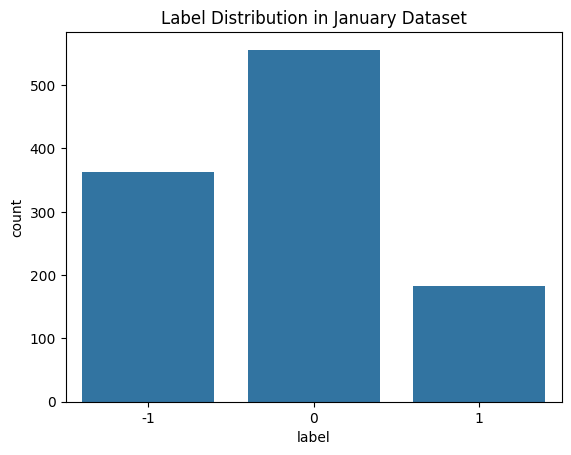

In [3]:
sns.countplot(x='label', data=df_jan)
plt.title('Label Distribution in January Dataset')
plt.savefig("results/bert_embeddings_experiment_v2/figures/label_distribution_january.png")
plt.show()

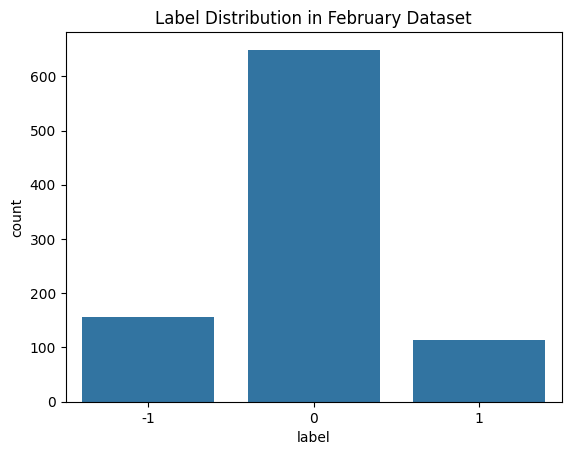

In [4]:
sns.countplot(x='label', data=df_feb)
plt.title('Label Distribution in February Dataset')
plt.savefig("results/bert_embeddings_experiment_v2/figures/label_distribution_february.png")
plt.show()

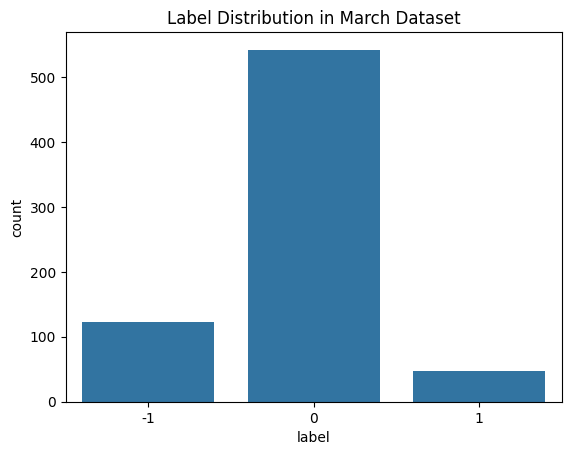

In [5]:
sns.countplot(x='label', data=df_march)
plt.title('Label Distribution in March Dataset')
plt.savefig("results/bert_embeddings_experiment_v2/figures/label_distribution_march.png")
plt.show()

In [6]:
import re

def normalize_numbers(text):
    # Replace monetary values (e.g., "R$ 15 bilhões" → "15B")
    text = re.sub(r"R\$ ?([\d.,]+) bilhões", r"\1B", text)
    text = re.sub(r"R\$ ?([\d.,]+) milhões", r"\1M", text)
    # Standardize percentages (e.g., "0.5 pp" → "0.5%")
    text = re.sub(r"([\d.,]+) pp", r"\1%", text)
    # Standardize plain numbers (e.g., "15,000" → "15000")
    text = text.replace(",", "")
    return text

In [7]:
def remove_noise(text):
    # Remove dates and times
    text = re.sub(r"\b\d{1,2}[hH]\d{2}\b", "", text)  # Times like "17h20"
    text = re.sub(r"\b\d{1,2}ª[Ff]\b", "", text)       # Ordinals like "2ªF"
    # Remove redundant words
    text = re.sub(r"MAIS AGENDA|LÁ FORA|A BOLSA ESTÁ CARA", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [8]:
import re

# Comprehensive dictionary for expanding acronyms
acronyms = {
    "Selic": "Sistema Especial de Liquidação e de Custódia",
    "PIB": "Produto Interno Bruto",
    "CDI": "Certificado de Depósito Interbancário",
    "LPRs": "Loan Prime Rates",
    "Ibovespa": "Índice Bovespa",
    "BB": "Banco do Brasil",
    "BC": "Banco Central",
    "FGTS": "Fundo de Garantia do Tempo de Serviço",
    "STF": "Supremo Tribunal Federal",
    "CPI": "Índice de Preços ao Consumidor",
    "MP": "Medida Provisória",
    "EUA": "Estados Unidos",
    "ONU": "Organização das Nações Unidas",
    "FGV": "Fundação Getúlio Vargas",
    "IBGE": "Instituto Brasileiro de Geografia e Estatística",
    "BNDES": "Banco Nacional de Desenvolvimento Econômico e Social",
    "IPCA": "Índice Nacional de Preços ao Consumidor Amplo",
    "DI": "Depósito Interfinanceiro",
    "IR": "Imposto de Renda",
    "OI": "Operadora Oi",
    "CV": "Câmara de Vereadores"
}

noisy_acronyms = {"ROMI", "ENEVA", "LIGHT", "DA"}

def expand_acronyms(text, acronym_dict):
    for acronym, full_form in acronym_dict.items():
        text = re.sub(rf'\b{re.escape(acronym)}\b', full_form, text, flags=re.IGNORECASE)
    return text

def remove_noisy_acronyms(text, noisy_set):
    return re.sub(r'\b(?:' + '|'.join(noisy_set) + r')\b', '', text)

In [9]:
import spacy

# Load Portuguese spaCy model
nlp = spacy.load("pt_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

In [10]:
def preprocess_text(text):
    text = normalize_numbers(text)         
    text = expand_acronyms(text, acronyms)
    text = remove_noisy_acronyms(text, noisy_acronyms)
    text = lemmatize_text(text)          
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

# Apply preprocessing to the dataset
df_jan['cleaned_article'] = df_jan['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)
df_feb['cleaned_article'] = df_feb['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)
df_march['cleaned_article'] = df_march['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)

In [11]:
# Load BERTimbau tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch

def get_bert_embedding(text, tokenizer, model):
    # tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # pass inputs through model
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract [CLS] token embedding (shape: [batch_size, hidden_size])
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token is the first token
    return cls_embedding.squeeze(0).numpy()  # convert to NumPy array

In [13]:
df_jan['embedding'] = df_jan['cleaned_article'].apply(lambda x: get_bert_embedding(x, tokenizer, model))
df_feb['embedding'] = df_feb['cleaned_article'].apply(lambda x: get_bert_embedding(x, tokenizer, model))
df_march['embedding'] = df_march['cleaned_article'].apply(lambda x: get_bert_embedding(x, tokenizer, model))

## Generate Sentiment Analysis Labels

In [14]:
from transformers import AutoTokenizer, BertForSequenceClassification
import os
import pandas as pd
import re
from IPython.display import display

In [15]:
from transformers import (
    AutoTokenizer, 
    BertForSequenceClassification,
    pipeline,
)

tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
finbertptbr = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

In [16]:
classification_mapper = {
    0: 1,  # POSITIVE -> +1
    1: -1, # NEGATIVE -> -1
    2: 0   # NEUTRAL -> 0
}

In [17]:
def classify_article(article):
    try:
        # Tokenize the article
        tokens = tokenizer([article], return_tensors="pt", padding=True, truncation=True, max_length=512)
        # Get model outputs
        outputs = finbertptbr(**tokens)
        # Map predictions to classifications
        pred_index = np.argmax(outputs.logits.cpu().detach().numpy(), axis=1)[0]
        return classification_mapper[pred_index]
    except Exception as e:
        print(f"Error processing article: {article} | Error: {e}")
        return None

In [18]:
# Apply the classification function to each DataFrame
df_jan['classification'] = df_jan['cleaned_article'].apply(classify_article)
df_feb['classification'] = df_feb['cleaned_article'].apply(classify_article)
df_march['classification'] = df_march['cleaned_article'].apply(classify_article)

In [19]:
# Function to add classification to the embedding vector
def augment_embedding_with_classification(row):
    embedding = np.array(row['embedding'])  # Ensure embedding is a numpy array
    classification = np.array([row['classification']])  # Convert classification to an array
    return np.concatenate((embedding, classification))

# Apply the function to augment embeddings with classification
df_jan['embedding'] = df_jan.apply(augment_embedding_with_classification, axis=1)
df_feb['embedding'] = df_feb.apply(augment_embedding_with_classification, axis=1)
df_march['embedding'] = df_march.apply(augment_embedding_with_classification, axis=1)

## Logistic Regression Classification

In [20]:
# Combine January and February data for training
df_train_multi = pd.concat([df_jan, df_feb])
X_train_multi = np.vstack(df_train_multi['embedding'].values)
y_train_multi = df_train_multi['label']

# multi classification and test on march
X_test_multi = np.vstack(df_march['embedding'].values)
y_test_multi = df_march['label']

# binary Classification and test on march
df_train_binary = df_train_multi[df_train_multi['label'] != 0]
df_march_binary = df_march[df_march['label'] != 0]

X_train_binary = np.vstack(df_train_binary['embedding'].values)
y_train_binary = df_train_binary['label']

X_test_binary = np.vstack(df_march_binary['embedding'].values)
y_test_binary = df_march_binary['label']

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train multi-class classifier
multi_clf = LogisticRegression(max_iter=1000)
multi_clf.fit(X_train_multi, y_train_multi)

# Predict and evaluate
y_pred_multi = multi_clf.predict(X_test_multi)
print("Multi-Class Report:\n", classification_report(y_test_multi, y_pred_multi))

Multi-Class Report:
               precision    recall  f1-score   support

          -1       0.33      0.41      0.37       123
           0       0.84      0.77      0.80       542
           1       0.16      0.19      0.17        48

    accuracy                           0.67       713
   macro avg       0.44      0.46      0.45       713
weighted avg       0.70      0.67      0.69       713



In [22]:
# Train binary classifier
binary_clf = LogisticRegression(max_iter=1000)
binary_clf.fit(X_train_binary, y_train_binary)

# Predict and evaluate
y_pred_binary = binary_clf.predict(X_test_binary)
print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary))

Binary Classification Report:
               precision    recall  f1-score   support

          -1       0.75      0.79      0.77       123
           1       0.37      0.31      0.34        48

    accuracy                           0.65       171
   macro avg       0.56      0.55      0.55       171
weighted avg       0.64      0.65      0.65       171



In [23]:
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "results/bert_embeddings_experiment_v2/metrics"
os.makedirs(results_dir, exist_ok=True)

cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
class_report = classification_report(y_test_multi, y_pred_multi, target_names=["-1", "0", "1"])

report_path = os.path.join(results_dir, "classification_report_multi.txt")
with open(report_path, "w") as f:
    f.write("Classification Report:\n")
    f.write(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt="d", cmap="Blues",
            xticklabels=["-1", "0", "1"], yticklabels=["-1", "0", "1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Multi-Class Confusion Matrix")

conf_matrix_path = os.path.join(results_dir, "confusion_matrix_multi.png")
plt.savefig(conf_matrix_path)
plt.close()

print(f"Classification report saved to: {report_path}")
print(f"Confusion matrix saved to: {conf_matrix_path}")

Classification report saved to: results/bert_embeddings_experiment_v2/metrics\classification_report_multi.txt
Confusion matrix saved to: results/bert_embeddings_experiment_v2/metrics\confusion_matrix_multi.png


In [24]:
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
class_report_binary = classification_report(y_test_binary, y_pred_binary, target_names=["-1", "1"])

report_path_binary = os.path.join(results_dir, "classification_report_binary.txt")
with open(report_path_binary, "w") as f:
    f.write("Classification Report (Binary):\n")
    f.write(class_report_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Binary Confusion Matrix")

conf_matrix_path_binary = os.path.join(results_dir, "confusion_matrix_binary.png")
plt.savefig(conf_matrix_path_binary)
plt.close()

print(f"Binary classification report saved to: {report_path_binary}")
print(f"Binary confusion matrix saved to: {conf_matrix_path_binary}")

Binary classification report saved to: results/bert_embeddings_experiment_v2/metrics\classification_report_binary.txt
Binary confusion matrix saved to: results/bert_embeddings_experiment_v2/metrics\confusion_matrix_binary.png


## KNN Classification

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def knn_binary_classification(df_train, df_test, k=5):
    df_train_binary = df_train[df_train['label'] != 0]
    df_test_binary = df_test[df_test['label'] != 0]
    
    X_train = np.vstack(df_train_binary['embedding'].values)
    y_train = df_train_binary['label']
    X_test = np.vstack(df_test_binary['embedding'].values)
    y_test = df_test_binary['label']
    
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    print("Binary Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
    plot_confusion_matrix(cm, labels=[-1, 1], title="Confusion Matrix: Binary Classification")

def knn_multi_classification(df_train, df_test, k=5):
    X_train = np.vstack(df_train['embedding'].values)
    y_train = df_train['label']
    X_test = np.vstack(df_test['embedding'].values)
    y_test = df_test['label']
    
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    print("Multi-class Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    plot_confusion_matrix(cm, labels=[-1, 0, 1], title="Confusion Matrix: Multi-class Classification")

df_train = pd.concat([df_jan, df_feb])

Binary Classification (KNN):
Binary Classification Report:
              precision    recall  f1-score   support

          -1       0.74      0.93      0.82       123
           1       0.47      0.15      0.22        48

    accuracy                           0.71       171
   macro avg       0.60      0.54      0.52       171
weighted avg       0.66      0.71      0.66       171

Accuracy: 0.7134502923976608


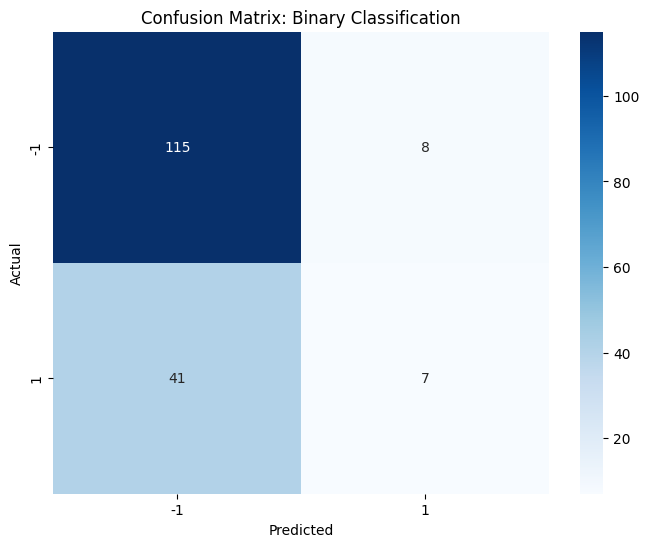


Multi-class Classification (KNN):
Multi-class Classification Report:
              precision    recall  f1-score   support

          -1       0.36      0.56      0.44       123
           0       0.84      0.79      0.81       542
           1       0.07      0.02      0.03        48

    accuracy                           0.70       713
   macro avg       0.42      0.46      0.43       713
weighted avg       0.71      0.70      0.70       713

Accuracy: 0.6956521739130435


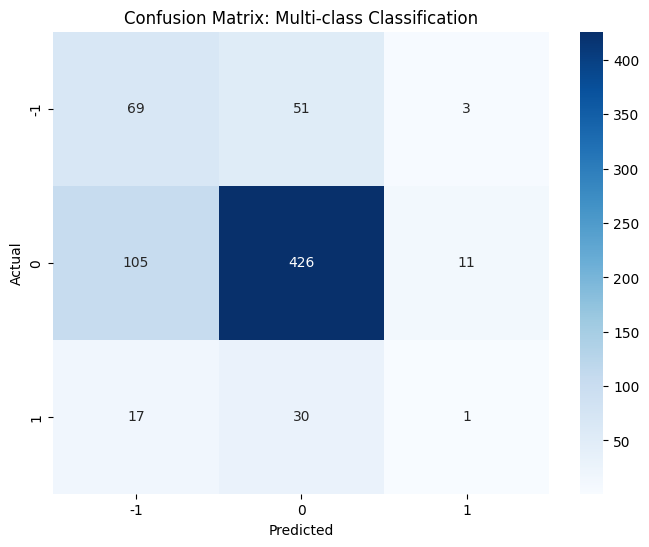

In [26]:
print("Binary Classification (KNN):")
knn_binary_classification(df_train, df_march, k=5)

print("\nMulti-class Classification (KNN):")
knn_multi_classification(df_train, df_march, k=5)